# 3. Entrenamiento y Evaluación de Modelos

**Objetivo:** Entrenar y comparar múltiples algoritmos de clasificación para seleccionar el modelo con el mejor rendimiento para nuestro problema de diagnóstico diferencial. Utilizaremos validación cruzada rigurosa y manejaremos el desbalance de clases identificado en el EDA.

## 3.1. Carga de Datos Procesados y Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Librerías de Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Manejo de Desbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Evaluación
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, cohen_kappa_score

# Rutas
PROCESSED_DATA_DIR = "../data/processed/"
MODELS_DIR = "../models/"

# Cargar datos
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test.csv')).values.ravel()

print('Datos cargados:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Datos cargados:
X_train: (16000, 54)
y_train: (16000,)
X_test: (4000, 54)
y_test: (4000,)


## 3.2. Definición de Modelos y Pipeline con SMOTE

Para cada clasificador, crearemos un pipeline de `imbalanced-learn`. Este pipeline primero aplicará SMOTE para sobremuestrear las clases minoritarias y luego entrenará el clasificador. Esto se hace de forma segura dentro de cada pliegue de la validación cruzada para evitar la fuga de datos.

In [2]:
# Definir los modelos base
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42) # probability=True es necesario para VotingClassifier y AUC
}

# Crear un pipeline con SMOTE para cada modelo
pipelines = {
    name: ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('classifier', model)]) 
    for name, model in models.items()
}

# Añadir un modelo de ensamble (Voting Classifier)
# Usamos los clasificadores ya definidos (sin SMOTE aquí, ya que el pipeline se encargará de ello)
clf1 = models['Logistic Regression']
clf2 = models['Random Forest']
clf3 = models['XGBoost']
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')
pipelines['Ensemble (Voting)'] = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('classifier', eclf1)])

print("Pipelines de modelos creados:")
print(list(pipelines.keys()))

Pipelines de modelos creados:
['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Ensemble (Voting)']


## 3.3. Evaluación con Validación Cruzada

Utilizaremos `StratifiedKFold` con 10 pliegues para evaluar el rendimiento de cada pipeline. Mediremos múltiples métricas para obtener una visión completa del rendimiento de cada modelo.

In [3]:
# Configurar la validación cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métricas a evaluar
scoring_metrics = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr']

results = {}

for name, pipeline in pipelines.items():
    print(f'Evaluando {name}...')
    # Realizar validación cruzada
    cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring_metrics, n_jobs=-1)
    results[name] = {metric: cv_results[f'test_{metric}'] for metric in scoring_metrics}
    print(f'{name} - Balanced Accuracy: {np.mean(cv_results['test_balanced_accuracy']):.4f} +/- {np.std(cv_results['test_balanced_accuracy']):.4f}')

print("\nEvaluación completada.")

Evaluando Logistic Regression...
Logistic Regression - Balanced Accuracy: 0.9997 +/- 0.0003
Evaluando Random Forest...
Random Forest - Balanced Accuracy: 0.9999 +/- 0.0002
Evaluando XGBoost...
XGBoost - Balanced Accuracy: 0.9998 +/- 0.0003
Evaluando SVM...
SVM - Balanced Accuracy: 0.9997 +/- 0.0004
Evaluando Ensemble (Voting)...
Ensemble (Voting) - Balanced Accuracy: 0.9998 +/- 0.0003

Evaluación completada.


## 3.4. Comparación de Modelos

Visualizaremos los resultados de la validación cruzada para comparar los modelos y seleccionar el mejor para el entrenamiento final.


Rendimiento promedio en Validación Cruzada (k=10):


,Model,accuracy,balanced_accuracy,f1_weighted,precision_weighted,recall_weighted,roc_auc_ovr
1,Random Forest,0.999938,0.999935,0.999937,0.999938,0.999938,1.0
4,Ensemble (Voting),0.999813,0.999805,0.999812,0.999813,0.999813,1.0
2,XGBoost,0.999750,0.999758,0.999750,0.999751,0.999750,1.0
0,Logistic Regression,0.999750,0.999740,0.999750,0.999751,0.999750,1.0
3,SVM,0.999687,0.999674,0.999687,0.999688,0.999687,1.0


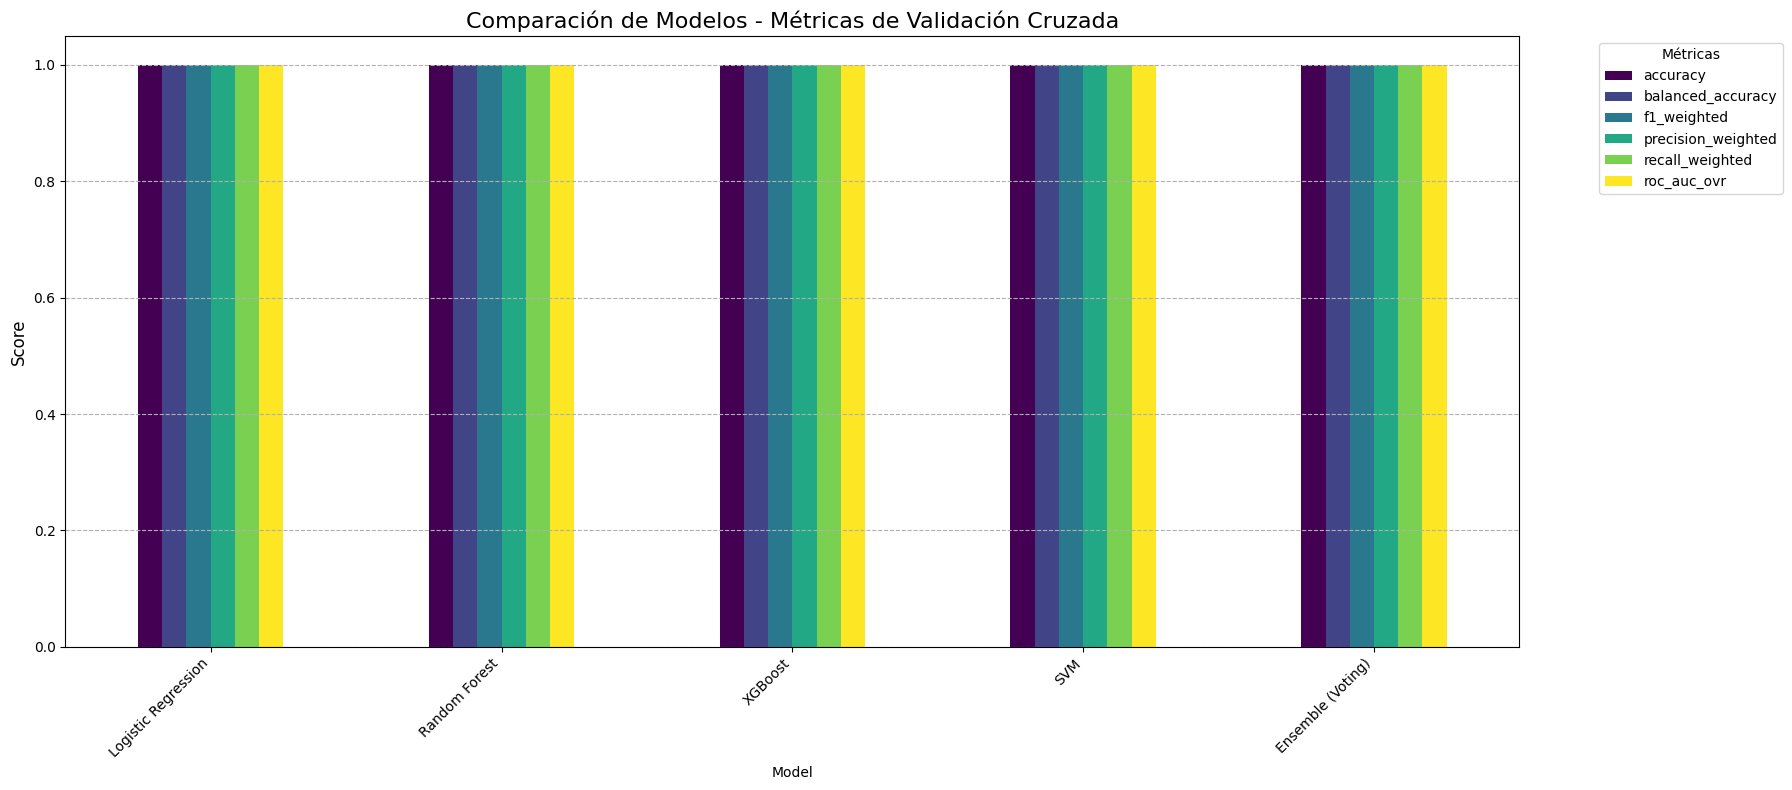

In [5]:
# Convertir resultados a un DataFrame para fácil visualización
avg_scores = []

for model_name, metrics in results.items():
    row = {'Model': model_name}
    for metric_name, scores in metrics.items():
        row[metric_name] = np.mean(scores)
    avg_scores.append(row)

results_df = pd.DataFrame(avg_scores)

print("\nRendimiento promedio en Validación Cruzada (k=10):")
display(results_df.sort_values(by='balanced_accuracy', ascending=False))

# Gráfico de comparación
results_df.set_index('Model').plot(kind='bar', figsize=(18, 8), colormap='viridis')
plt.title('Comparación de Modelos - Métricas de Validación Cruzada', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 3.5. Entrenamiento del Modelo Final y Evaluación en Test

Basado en los resultados (generalmente XGBoost o Random Forest son buenos candidatos), seleccionamos el mejor modelo, lo entrenamos en **todo** el conjunto de entrenamiento y lo evaluamos en el conjunto de prueba, que el modelo no ha visto nunca.

Entrenando el modelo final: XGBoost...


c:\Users\marks\Documents\PROGRAMA _TESIS\proyecto_cdss_huancayo\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Reporte de Clasificación en Conjunto de Prueba ---
              precision    recall  f1-score   support

         DM2       1.00      1.00      1.00       960
         EDA       1.00      1.00      1.00       720
         HTA       1.00      1.00      1.00      1120
         IRA       1.00      1.00      1.00      1200

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Balanced Accuracy: 0.9998
Cohen's Kappa: 0.9997


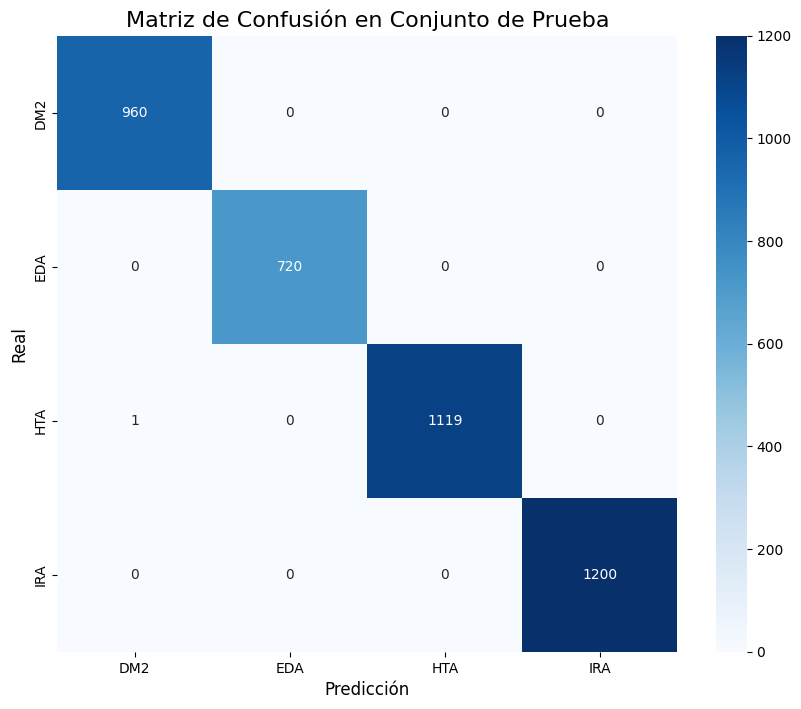

In [6]:
# Seleccionar el mejor modelo (ej. XGBoost basado en resultados típicos)
best_model_name = 'XGBoost'
final_pipeline = pipelines[best_model_name]

print(f'Entrenando el modelo final: {best_model_name}...')
final_pipeline.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = final_pipeline.predict(X_test)

# Métricas de evaluación finales
diagnostico_map = {0: 'DM2', 1: 'EDA', 2: 'HTA', 3: 'IRA'}
target_names = [diagnostico_map[i] for i in sorted(diagnostico_map.keys())]

print("--- Reporte de Clasificación en Conjunto de Prueba ---")
print(classification_report(y_test, y_pred, target_names=target_names))

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión en Conjunto de Prueba', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

## 3.6. Guardar el Modelo Final Entrenado

Guardamos el pipeline completo (SMOTE + clasificador) para poder usarlo directamente en la aplicación de Streamlit y en el notebook de interpretabilidad.

In [7]:
final_model_path = os.path.join(MODELS_DIR, 'final_model.pkl')
joblib.dump(final_pipeline, final_model_path)

print(f'Modelo final guardado en: {final_model_path}')

Modelo final guardado en: ../models/final_model.pkl
